# Current through a molecule: the 4LS model

In this notebook I will investigate:
- how current passes through a (more realistic) molecule between two fermionic leads - this model is set up for modelling molecular photovoltaics so includes the two unoccupied electronic states, as well as the totally empty and totally filled states.
- Study effects of lead non-additivity
- how photocurrent is induced when the molecule is incident to a (hot) thermal electromagnetic environment
- The effects of lead and phonon non-additivity on photocurrent


In [2]:
%matplotlib inline

import time
import numpy as np

import matplotlib.pyplot as plt
import qutip as qt
from scipy import integrate


#import fermionic_leads as fl

import UD_liouv as RC
import driving_liouv as EM

import phonon_weak_coupling as WC

from qutip import ket, basis, sigmam, sigmap, sigmaz, spre, sprepost, spost, destroy, mesolve, tensor, qeye, Qobj
from numpy import pi, linspace, sqrt
#from fermionic_leads import non_additive_lead_dissipator, additive_lead_dissipator, current_from_L
from utils import J_overdamped, beta_f, J_underdamped, J_minimal_hard, J_multipolar
from utils import ground_and_excited_states, initialise_TLS

# First: lets create the additive lead Liouvillians

In [3]:

kB = 0.695
EE = basis(2,1)*basis(2,1).dag()
GG = basis(2,0)*basis(2,0).dag()
Zero = tensor(basis(2,0), basis(2,0))
sz = EE - GG
sm = destroy(2)
d2 = tensor(sm, sz) # swapped around from the calculations
d1 = tensor(qeye(2), sm)

d1dag, d2dag = d1.dag(), d2.dag()

z_ket = basis(4,0)
l_ket = basis(4,1)
lp_ket = basis(4,2)
d_ket = basis(4,3)
D = d1dag*d1*d2dag*d2
Z = Qobj(z_ket*z_ket.dag(), dims=D.dims)
LUMO = Qobj(l_ket*l_ket.dag(), dims=D.dims)
LUMOp = Qobj(lp_ket*lp_ket.dag(), dims=D.dims)

d1_ = z_ket*l_ket.dag() + lp_ket*d_ket.dag()
d2_ = l_ket*d_ket.dag() - z_ket*lp_ket.dag()
print d1dag*d1, d2dag*d2, d1_.dag()*d1_, d2_.dag()*d2_
eps1, eps2 =  100., 1000.
U = 10.
mu = 100
T = 100
Gamma_l = 1.

n = d1dag*d1 + d2dag*d2

J_leads = J_underdamped
def build_H(eps1, eps2, U):
    return eps1*d1dag*d1 + eps2*d2dag*d2 + U*D

def build_general_ME(d1, d2):
    L = 2. * spre(O) * spost(Od) - spre(Od * O) - spost(Od * O)
    return L

def commutator_term1(O1, O2):
    # [O1, O2*rho]
    return spre(O1*O2)-sprepost(O2, O1)  

def commutator_term2(O1, O2):
    # [rho*O1, O2]
    return spost(O1*O2)-sprepost(O2, O1)

def fermi_occ(eps, T, mu):
    exp_part = np.exp((eps-mu)/(kB*T))
    return 1/(exp_part+1)

def current_from_L(H, L_full, L_track, n, method='direct'):
    use_precond = False
    if method!='direct':
        use_precond = True
    rho_ss = qt.steadystate(H, [L_full], method=method, use_precond=use_precond)
    time_dependence = (qt.vector_to_operator(L_track*qt.operator_to_vector(rho_ss))*n).tr()
    return -time_dependence

def cauchyIntegrands(eps, J, height, width, pos, T, mu, ver=1):
    # Function which will be called within another function where other inputs
    # are defined locally
    F = 0
    if ver == -1:
        F = J(eps, height, width, pos)*(1-fermi_occ(eps, T, mu))
    elif ver == 1:
        F = J(eps, height, width, pos)*(fermi_occ(eps, T, mu))
    return F

    
def Lamdba_complex_rate(eps, J, mu, T, height, width, pos, type='m', plot_integrands=False, real_only=False):
    F_p = (lambda x: (cauchyIntegrands(x, J, height, width, pos, T, mu, ver=1)))
    F_m = (lambda x: (cauchyIntegrands(x, J, height, width, pos, T, mu, ver=-1)))
    if plot_integrands:
        w = np.linspace(0,4*eps, 300)
        plt.plot(w, F_p(w), label='+')
        plt.plot(w, F_m(w), label='-')
        plt.legend()
    if type=='m':
        if real_only:
            Pm=0.
        else:
            Pm = integrate.quad(F_m, 0, 5*eps, weight='cauchy', wvar=eps)[0]
        
        return pi*F_m(eps) + 1j*Pm
    elif type=='p':
        if real_only:
            Pp=0.
        else:
            Pp = integrate.quad(F_p, 0, 5*eps, weight='cauchy', wvar=eps)[0] #integral_converge(F_p, 0, eps)
        return pi*F_p(eps) + 1j*Pp
    else:
        raise ValueError

def additive_liouvillian(eps1 =0., eps2=900., T_L=77., mu_L=1000.,
                         width_L=1000., pos_L=900., height_L=1., T_R=77.,
                         mu_R=0., width_R=1000., pos_R=900., height_R=1.,
                        secular=False, real_only=False):
    J = J_leads
    eps = [eps1, eps2]
    width = [width_L, width_R]
    pos = [pos_L, pos_R]
    T = [T_L, T_R]
    mu = [mu_L, mu_R]
    height= [height_L, height_R]
    L = []
    d = [d1, d2]
    ddag = [d1dag, d2dag]
    #_ = Lamdba_complex_rate(eps2, J, mu[0], T[0], height[0], width[0], pos[0], type='m', plot_integrands=True)
    #_ = Lamdba_complex_rate(eps2, J, mu[1], T[1], height[1], width[1], pos[1], type='m', plot_integrands=True)
    for j in range(2): # over leads
        
        L_j = 0
        for q in range(2): # over sites
            for p in range(2):
                if secular and p!=q:
                    pass
                else:
                    L_j += Lamdba_complex_rate(eps[p], J, mu[j], 
                                             T[j], height[j],
                                             width[j], pos[j], 
                                             type='p',real_only=real_only)*commutator_term1(d[q], ddag[p])
                                                                        
                    L_j += Lamdba_complex_rate(eps[p], J, mu[j], 
                                             T[j], height[j],
                                             width[j], pos[j], 
                                             type='m',real_only=real_only)*commutator_term2(ddag[p], d[q])
                    L_j += Lamdba_complex_rate(eps[p], J, mu[j], 
                                             T[j], height[j],
                                             width[j], pos[j], 
                                             type='m',real_only=real_only).conjugate()*commutator_term1(ddag[q], d[p])
                    L_j += Lamdba_complex_rate(eps[p], J, mu[j], 
                                             T[j], height[j],
                                             width[j], pos[j], 
                                             type='p',real_only=real_only).conjugate()*commutator_term2(d[p], ddag[q])
        L.append(L_j)
    return -L[0], -L[1]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  1.]] Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]] Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  1.]] Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


In [7]:
eps1=100.
eps2=900.
T_L=77.
width_L=1000.
mu_L=eps2+100
pos_L=eps2
T_R=77.
mu_R=0.
width_R=1000.
pos_R=eps2
height_L = 0.5
height_R=0.5

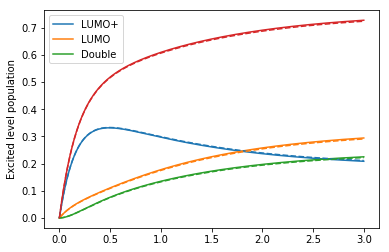

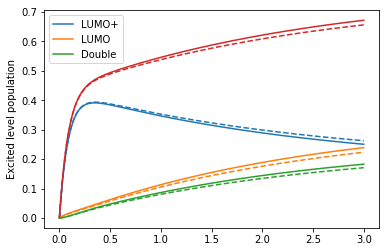

In [3]:

def compare_sec_and_nonsec(eps1=100., eps2=1000., U=0., T_L=77., mu_L=1000.,
                         width_L=1000., pos_L=900., height_L=1., T_R=77.,
                         mu_R=0., width_R=1000., pos_R=900., height_R=1.):
    L_L, L_R = additive_liouvillian(eps1=eps1, eps2=eps2, T_L=T_L, mu_L=mu_L, 
                             width_L=width_L, pos_L=pos_L, T_R=T_R,
                             mu_R=mu_R, width_R=width_R, pos_R=pos_R, 
                                    height_L=height_L, height_R=height_R)
    #print L_L
    H = build_H(eps1, eps2, U)
    timelist = np.linspace(0,3,1000)
    rho0 = Zero*Zero.dag()
    elist = [LUMOp, LUMO, D, LUMOp+LUMO+D]
    #print H.dims, rho0.dims, L_R.dims, L_L.dims, elist[0].dims
    data = mesolve(H, rho0, timelist, [L_L+L_R], elist)
    #rho_ss_num = (-((1/(kB*T))*H-mu*n)).expm()
    #rho_ss = rho_ss_num/rho_ss_num.tr()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.figure()
    plt.plot(timelist, data.expect[0], label='LUMO+', color=colors[0])
    plt.plot(timelist, data.expect[1], label='LUMO', color=colors[1])
    plt.plot(timelist, data.expect[2], label='Double', color=colors[2])
    plt.plot(timelist, data.expect[0]+data.expect[1]+data.expect[2], color=colors[3])
    plt.ylabel("Excited level population")
    plt.legend()
    #plt.axhline((rho_ss*elist[0]).tr(), ls='dashed', color='r')
    L_L, L_R = additive_liouvillian(eps1=eps1, eps2=eps2, T_L=T_L, 
                             width_L=width_L, pos_L=pos_L, T_R=T_R,
                             mu_R=mu_R, width_R=width_R, pos_R=pos_R,
                                    height_L=height_L, height_R=height_R
                                   ,secular=True)
    data = mesolve(H, rho0, timelist, [L_L+L_R], elist)
    plt.plot(timelist, data.expect[0], ls='dashed', color=colors[0])
    plt.plot(timelist, data.expect[1], ls='dashed', color=colors[1])
    plt.plot(timelist, data.expect[2], ls='dashed', color=colors[2])
    plt.plot(timelist, data.expect[0]+data.expect[1]+data.expect[2], ls='dashed', color=colors[3])
    plt.show()
    
compare_sec_and_nonsec(eps1=eps1, eps2=eps2, T_L=T_L, mu_L=mu_L, 
                             width_L=width_L, pos_L=pos_L, T_R=T_R,
                             mu_R=mu_R, width_R=width_R, pos_R=pos_R,
                              height_L=height_L, height_R=height_R)

compare_sec_and_nonsec(eps1=eps1, eps2=eps2, T_L=T_L, mu_L=mu_L, 
                             width_L=0.5*width_L, pos_L=pos_L, T_R=T_R,
                             mu_R=mu_R, width_R=0.5*width_R, pos_R=pos_R,
                              height_L=height_L, height_R=height_R)

As we can see in the first example above, at weak-coupling and intermediate bias the non-secular coupling terms have the effect of slightly increasing the electronic population states. For the same bias, but narrower SD (more strongly coupled to the LUMO+ state) the off-diagonal terms have a much larger effect on LUMO and Double, but leave LUMO+ unchanged. I think this is because the faster hopping rates on the leads will cause the zero state to be inhabited far less often.

## First: current-voltage diagrams in absence of phonons

In [9]:

def simple_current_voltage(eps1=100., eps2=900., U=0., T_L=77., 
                         width_L=1000., pos_L=900., T_R=77.,
                         mu_R=0., width_R=1000., pos_R=1000.,
                               secular=True, mu_L_max =2000):
    H = build_H(eps1, eps2, U)
    mu_Ls = np. linspace(0, mu_L_max, 100)
    currents = []
    for mu_L in mu_Ls:
        L_L, L_R = additive_liouvillian(eps1=eps1, eps2=eps2,  mu_L=mu_L,T_L=T_L, 
                         width_L=width_L, pos_L=pos_L, T_R=T_R,
                         mu_R=mu_R, width_R=width_R, pos_R=pos_R,
                               secular=secular)
        currents.append(current_from_L(H, L_L+L_R, L_R, n))
    return mu_Ls-mu_R, currents

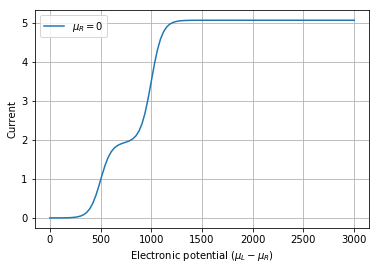

In [10]:
eps = 1000.
mu_L_max = 3000
width = eps
pos= eps
v1, c1 = simple_current_voltage(eps1=500., eps2=1000., T_L=77., 
                         width_L=1000., pos_L=1000., T_R=77.,
                         mu_R=0., width_R=1000., pos_R=1000.,
                               secular=True, mu_L_max=mu_L_max)
"""v2, c2 = simple_current_voltage(eps, T, width, pos, T, -100, width, pos, mu_L_max =mu_L_max)
v3, c3 = simple_current_voltage(eps, 300., width, pos, 300., 0, width, pos, mu_L_max =mu_L_max)
v4, c4 = simple_current_voltage(eps, 100., width, pos, 1000., 0, width, pos, mu_L_max =mu_L_max) 
v5, c5 = simple_current_voltage(eps, 1000., width, pos, 100., 0, width, pos, mu_L_max =mu_L_max)"""
plt.plot(v1, c1, label='$\mu_R=0$')
"""plt.plot(v2, c2, label='$\mu_R=-100$')
plt.plot(v3, c3, label='$T_L=300K, T_R=300K$')
plt.plot(v4, c4, label='$T_L=100K, T_R=1000K$')
plt.plot(v5, c5, label='$T_L=1000K, T_R=100K$')"""
plt.xlabel("Electronic potential ($\mu_L-\mu_R$)")
plt.ylabel("Current")
plt.grid()
plt.legend()
plt.show()

The normal current-voltage relations are reproduced:
- steps as the energy levels enter into the 

## Non-additive lead dissipators

In [4]:

def L_R_lead_dissipators(H, A, T_L=77., mu_L=1000.,
                     width_L=1000., pos_L=900., height_L=1., T_R=77.,
                     mu_R=0., width_R=1000., pos_R=900., height_R=1.,
                        real_only=False):
    L_leads = []
    T = [T_L, T_R]
    mu = [mu_L, mu_R]
    Gamma_0 = [height_L, height_R]
    width =[width_L, width_R]
    pos = [pos_L, pos_R]
    evals, estates = H.eigenstates()
    Z = []
    J = J_underdamped
    dim = len(evals)
    Adag = A.dag()
    for j in range(2): # for left and right lead
        Zp_1, Zp_2, Zm_1, Zm_2 = 0,0,0,0
        for l in range(dim):
            for k in range(dim):
                e_lk = abs(evals[l]- evals[k])
                A_kl = A.matrix_element(estates[k].dag(), estates[l])
                Adag_lk = Adag.matrix_element(estates[l].dag(), estates[k])
                LK = estates[l]*estates[k].dag()
                KL = estates[k]*estates[l].dag()
                if e_lk != 0:
                    rate_up = Lamdba_complex_rate(e_lk, J, mu[j], 
                                             T[j], Gamma_0[j],
                                             width[j], pos[j], 
                                             type='p',real_only=real_only)
                    rate_down = Lamdba_complex_rate(e_lk, J, mu[j], 
                                             T[j], Gamma_0[j],
                                             width[j], pos[j], 
                                             type='m',real_only=real_only)
                    Zp_1 += LK*Adag_lk*rate_up
                    Zp_2 += LK*Adag_lk*rate_down
                    Zm_1 += KL*A_kl*rate_up.conjugate()
                    Zm_2 += KL*A_kl*rate_down.conjugate()
                else:
                    pass
                    """rup, rdown = limit_fermi_flat(Gamma_0[j], T[j], mu[j])
                    Zp_1 += LK*Adag_lk*rup
                    Zp_2 += LK*Adag_lk*rdown
                    Zm_1 += KL*A_kl*rup
                    Zm_2 += KL*A_kl*rdown"""
        Z.append([Zp_1, Zp_2, Zm_1, Zm_2])
        
    #print Z_plus_1+Z_plus_2, Z_minus_1+Z_minus_2
    
    for j in range(2):
        Zp_1, Zp_2, Zm_1, Zm_2 = Z[j][0],Z[j][1],Z[j][2],Z[j][3]
        L=0
        L += spre(A*Zp_1)-sprepost(Zp_1, A)
        L += -sprepost(A, Zp_2)+spost(Zp_2*A)
        L += spre(Adag*Zm_2)-sprepost(Zm_2, Adag)
        L += -sprepost(Adag, Zm_1)+spost(Zm_1*Adag)
        L_leads.append(L)
    return -L_leads[0],-L_leads[1]

"""H = build_H(eps1, eps2, U)
L_L, L_R = L_R_lead_dissipators(H, d1+d2, T_L=77., mu_L=1000.,
                     width_L=1000., pos_L=900., height_L=1., T_R=77.,
                     mu_R=0., width_R=1000., pos_R=900., height_R=1.)"""

def nonadditive_current_voltage(eps1=500., eps2=900., U=0., T_L=77., 
                         width_L=1000., pos_L=900., height_L=1.,T_R=77.,
                         mu_R=0., width_R=1000., pos_R=1000.,height_R=1.,
                               secular=True, mu_L_max =2000):
    H = build_H(eps1, eps2, U)
    n = d1dag*d1 + d2dag*d2
    mu_Ls = np. linspace(0, mu_L_max, 100)
    currents = []
    for mu_L in mu_Ls:
        L_L, L_R = L_R_lead_dissipators(H, d1+d2, T_L=T_L, mu_L=mu_L,
                     width_L=width_L, pos_L=pos_L, height_L=height_L, T_R=T_R,
                     mu_R=mu_R, width_R=width_R, pos_R=pos_R, height_R=height_R)
        currents.append(current_from_L(H, L_L+L_R, L_R, n))
    return mu_Ls-mu_R, currents

In [8]:
H = build_H(eps1,eps2., 0.)
%timeit L_R_lead_dissipators(H, d1+d2, T_L=T_L, mu_L=mu_L, width_L=width_L, pos_L=pos_L, height_L=height_L, T_R=T_R,mu_R=mu_R, width_R=width_R, pos_R=pos_R, height_R=height_R)
%timeit L_R_lead_dissipators(H, d1+d2, T_L=T_L, mu_L=mu_L,width_L=width_L, pos_L=pos_L, height_L=height_L, T_R=T_R,mu_R=mu_R, width_R=width_R, pos_R=pos_R, height_R=height_R, real_only=True)

10 loops, best of 3: 84.1 ms per loop
10 loops, best of 3: 50.1 ms per loop


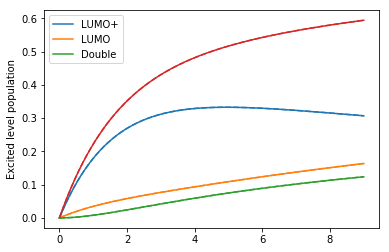

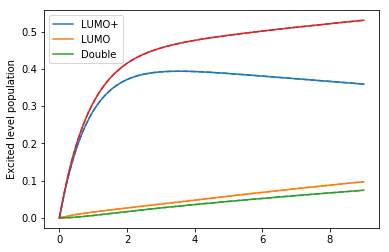

In [14]:
def compare_add_and_nonadd(eps1=100., eps2=1000., U=0., T_L=77., mu_L=1000.,
                         width_L=1000., pos_L=900., height_L=1., T_R=77.,
                         mu_R=0., width_R=1000., pos_R=900., height_R=1.):
    
    L_L, L_R = additive_liouvillian(eps1=eps1, eps2=eps2, 
                                    T_L=T_L, T_R=T_R,
                                    mu_L=mu_L, mu_R=mu_R,
                                    width_L=width_L, width_R=width_R,
                                    pos_L=pos_L, pos_R=pos_R,
                                    height_L=height_L, height_R=height_R,
                                    real_only=False)
    
    H = build_H(eps1, eps2, U)
    timelist = np.linspace(0,9,2000)
    rho0 = Z
    elist = [LUMOp, LUMO, D, LUMOp+LUMO+D]
    #print H.dims, rho0.dims, L_R.dims, L_L.dims, elist[0].dims
    data = mesolve(H, rho0, timelist, [L_L+L_R], elist)
    #rho_ss_num = (-((1/(kB*T))*H-mu*n)).expm()
    #rho_ss = rho_ss_num/rho_ss_num.tr()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.figure()
    plt.plot(timelist, data.expect[0], label='LUMO+', color=colors[0])
    plt.plot(timelist, data.expect[1], label='LUMO', color=colors[1])
    plt.plot(timelist, data.expect[2], label='Double', color=colors[2])
    plt.plot(timelist, data.expect[0]+data.expect[1]+data.expect[2], color=colors[3])
    plt.ylabel("Excited level population")
    plt.legend()
    #plt.axhline((rho_ss*elist[0]).tr(), ls='dashed', color='r')
    L_L, L_R = L_R_lead_dissipators(H, d1+d2,
                                    T_L=T_L, T_R=T_R,
                                    mu_L=mu_L, mu_R=mu_R,
                                    width_L=width_L, width_R=width_R,
                                    pos_L=pos_L, pos_R=pos_R,
                                    height_L=height_L, height_R=height_R, real_only=False)
    data = mesolve(H, rho0, timelist, [L_L+L_R], elist)
    plt.plot(timelist, data.expect[0], ls='dashed', color=colors[0])
    plt.plot(timelist, data.expect[1], ls='dashed', color=colors[1])
    plt.plot(timelist, data.expect[2], ls='dashed', color=colors[2])
    plt.plot(timelist, data.expect[0]+data.expect[1]+data.expect[2], ls='dashed', color=colors[3])
    plt.show()

eps1=100.
eps2=900.
U = 0.
T_L=77.
width_L=1000.
mu_L=eps2+100.
pos_L=eps2
T_R=77.
mu_R=0.
width_R=1000.
pos_R=eps2+0.
height_L = 0.05
height_R=0.05
    
compare_add_and_nonadd(eps1=eps1, eps2=eps2, U=U, T_L=T_L, mu_L=mu_L, 
                             width_L=width_L, pos_L=pos_L, T_R=T_R,
                             mu_R=mu_R, width_R=width_R, pos_R=pos_R,
                              height_L=height_L, height_R=height_R)

compare_add_and_nonadd(eps1=eps1, eps2=eps2, U=U, T_L=T_L, mu_L=mu_L, 
                             width_L=0.5*width_L, pos_L=pos_L, T_R=T_R,
                             mu_R=mu_R, width_R=0.5*width_R, pos_R=pos_R,
                              height_L=height_L, height_R=height_R)

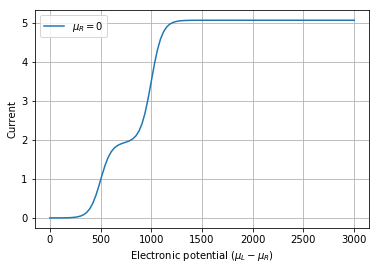

In [15]:


mu_L_max = 3000
width = eps
pos= eps
v1, c1 = nonadditive_current_voltage(eps1=500., eps2=1000., T_L=77., 
                         width_L=1000., pos_L=1000., T_R=77.,
                         mu_R=0., width_R=1000., pos_R=1000.,
                               secular=True, mu_L_max=mu_L_max)
"""v2, c2 = simple_current_voltage(eps, T, width, pos, T, -100, width, pos, mu_L_max =mu_L_max)
v3, c3 = simple_current_voltage(eps, 300., width, pos, 300., 0, width, pos, mu_L_max =mu_L_max)
v4, c4 = simple_current_voltage(eps, 100., width, pos, 1000., 0, width, pos, mu_L_max =mu_L_max) 
v5, c5 = simple_current_voltage(eps, 1000., width, pos, 100., 0, width, pos, mu_L_max =mu_L_max)"""
plt.plot(v1, c1, label='$\mu_R=0$')
"""plt.plot(v2, c2, label='$\mu_R=-100$')
plt.plot(v3, c3, label='$T_L=300K, T_R=300K$')
plt.plot(v4, c4, label='$T_L=100K, T_R=1000K$')
plt.plot(v5, c5, label='$T_L=1000K, T_R=100K$')"""
plt.xlabel("Electronic potential ($\mu_L-\mu_R$)")
plt.ylabel("Current")
plt.grid()
plt.legend()
plt.show()

The additive and non-additive theories agree in the correct limit! Next, to get the imaginary parts too

## Phonons and leads

Here I'll investigate current-voltage relations when including phonons. The exact same plots as above but with a single mode with a couple of different parameters.

In [9]:
def Ham_RC(H, n_op, sigma_op, Omega, kappa, N, rotating=False):
    """
    Input: System splitting, RC freq., system-RC coupling and Hilbert space dimension
    Output: Hamiltonian, sigma_- and sigma_z in the vibronic Hilbert space
    """
    if rotating:
        eps=0.
    a = destroy(N)
    shift = (kappa**2)/Omega
    I_sys = Qobj(qeye(sigma_op.shape[0]), dims=sigma_op.dims)
    I_RC = qeye(N)
    H_S = tensor(H, I_RC) + shift*tensor(n_op, I_RC)
    H_S += kappa*tensor(n_op, (a + a.dag())) + tensor(I_sys, Omega*a.dag()*a)
    A_em = tensor(sigma_op, qeye(N))
    A_nrwa = tensor(sigma_op+sigma_op.dag(), qeye(N))
    A_ph = tensor(I_sys, (a + a.dag()))
    return H_S, A_em, A_nrwa, A_ph



def RC_function_UD(H, n_op, sigma_op, T_ph, Gamma, wRC, alpha_ph, N, silent=False,
                                            residual_off=False, rotating=False):
    # we define all of the RC parameters by the underdamped spectral density
    gamma = Gamma / (2. * np.pi * wRC)  # coupling between RC and residual bath
    if residual_off:
        gamma=0
    kappa= np.sqrt(np.pi * alpha_ph * wRC / 2.)  # coupling strength between the TLS and RC

    if not silent:
        print "w_RC={} | TLS splitting = {} | RC-res. coupling={:0.2f} | TLS-RC coupling={:0.2f} | Gamma_RC={:0.2f} | alpha_ph={:0.2f} | N={} |".format(wRC, eps, gamma,  kappa, Gamma, alpha_ph, N)
    H, A_em, A_nrwa, A_ph = Ham_RC(H, n_op, sigma_op, wRC, kappa, N, rotating=rotating)
    L_RC, Z =  RC.liouvillian_build(H, A_ph, gamma, wRC, T_ph)
    return L_RC, H, A_em, A_nrwa, Z, wRC, kappa, Gamma

In [16]:
def current_vs_voltage_with_phonons(eps1=1000., eps2=1000., U= 0., T_ph=77, 
                                    Gamma=10., w0=50., alpha_ph=10., N=10, 
                                    Gamma_L=0.5, T_L=77., width_L=1000., pos_L=1000.,
                                    Gamma_R=0.5, T_R=77., mu_R=0., width_R=1000., pos_R=1000.,
                                   real_only=False):
    T_L = T_ph
    T_R = T_ph
    ti = time.time()
    mu_Ls = np. linspace(0, 30.*w0, 70)
    eps = abs(eps2-eps1)
    print "RC would need {} states to fill electronic gap.".format(eps/w0)
    currents = []
    
    H = build_H(eps1, eps2, U)
    L_RC, H_RC, A_EM, A_nrwa, Z, _, _, _, = RC_function_UD(H, n, d1+d2, T_ph, Gamma, w0, alpha_ph, 
                                                         N, silent=True)
    d_RC = tensor(d1+d2, qeye(N))
    E_RC = tensor(n, qeye(N))
    #timelist = np.linspace(0, 3/Gamma_EM, 360)
    for i, mu_L in enumerate(mu_Ls):
        
        L_L, L_R = L_R_lead_dissipators(H_RC, d_RC, T_L=T_L, mu_L=mu_L,
                         width_L=width_L, pos_L=pos_L, height_L=height_L, T_R=T_R,
                         mu_R=mu_R, width_R=width_R, pos_R=pos_R, height_R=height_R,
                         real_only=real_only)
        currents.append(current_from_L(H_RC, L_RC+L_L+L_R, L_R, E_RC))
        if (i%10)==0:
            print 100*(float(i)/len(mu_Ls)), "% complete"
    print "Took {} seconds.".format(time.time()-ti)
    return mu_Ls-mu_R, currents

In [17]:
eps1 = 800
width_scale = 8.
w_RC = 100.
v1, c1 = current_vs_voltage_with_phonons(eps1=eps1, eps2=200., U=0., T_ph=30., Gamma=20., 
                                        w0=w_RC, alpha_ph=50., N=13,
                                        width_L=w_RC*width_scale, width_R=w_RC*width_scale,
                                         pos_R=eps1, pos_L=eps1)

"""v2, c2 = current_vs_voltage_with_phonons(eps1=eps1, eps2=200., U=0., T_ph=30., Gamma=20., 
                                        w0=w_RC, alpha_ph=75., N=13,
                                        width_L=w_RC*width_scale, width_R=w_RC*width_scale,
                                         pos_R=eps1, pos_L=eps1)
w_RC = 0.695*150
v3, c3 = current_vs_voltage_with_phonons(eps1=eps1, eps2=200., U=0., T_ph=30., Gamma=20., 
                                        w0=w_RC, alpha_ph=75., N=13,
                                        width_L=w_RC*width_scale, width_R=w_RC*width_scale,
                                         pos_R=eps1, pos_L=eps1)
w_RC = 0.695*150
v4, c4 = current_vs_voltage_with_phonons(eps1=eps1, eps2=200., U=0., T_ph=30., Gamma=20., 
                                        w0=w_RC, alpha_ph=100., N=13,
                                        width_L=w_RC*width_scale, width_R=w_RC*width_scale,
                                         pos_R=eps1, pos_L=eps1)
v5, c5 = current_vs_voltage_with_phonons(eps1=eps1, eps2=200., U=0., T_ph=30., Gamma=100., 
                                        w0=w_RC, alpha_ph=100., N=13,
                                        width_L=w_RC*width_scale, width_R=w_RC*width_scale,
                                         pos_R=eps1, pos_L=eps1)"""
"""
w_RC = 0.695*150
v3, c3 = current_vs_voltage_with_phonons(eps1=eps1, eps2=200., U=0., T_ph=30., Gamma=100., 
                                        w0=w_RC, alpha_ph=100., N=16,
                                        width_L=w_RC*width_scale, width_R=w_RC*width_scale,
                                         pos_R=eps1, pos_L=eps1)"""
"""v2, c2 = current_vs_voltage_with_phonons(eps1=1000., eps2=200., U=0., T_ph=30., Gamma=30., 
                                        w0=w_RC, alpha_ph=100., N=16,
                                        width_L=w_RC*10, width_R=w_RC*10.,
                                         pos_R=1000., pos_L=1000.)"""
"""v1, c1 = current_vs_voltage_with_phonons(eps=100., T_ph=30., Gamma=sqrt(0.5)*w_RC**(3/2.), 
                                        w0=w_RC, alpha_ph=25., N=13,
                                        width_L=w_RC*10, width_R=w_RC*10.)
v2, c2 = current_vs_voltage_with_phonons(eps=100., T_ph=30., Gamma=sqrt(5)*w_RC**(3/2.), 
                                        w0=w_RC, alpha_ph=25., N=13,
                                        width_L=w_RC*10, width_R=w_RC*10)
v3, c3 = current_vs_voltage_with_phonons(eps=100., T_ph=30., Gamma=sqrt(5)*w_RC**(3/2.), 
                                        w0=w_RC, alpha_ph=75., N=13,
                                        width_L=w_RC*10, width_R=w_RC*10)"""
#v2, c2 = current_vs_voltage_with_phonons(eps=1000., T_ph=77, Gamma=10., w0=50., alpha_ph=10., N=10)
#v3, c3 = current_vs_voltage_with_phonons(eps=1000., T_ph=77, Gamma=10., w0=50., alpha_ph=50., N=17)
#v4, c4 = current_vs_voltage_with_phonons(eps=1000., T_ph=77, Gamma=25., w0=50., alpha_ph=50., N=17)
#v5, c5 = current_vs_voltage_with_phonons(eps=1000., T_ph=77, Gamma=10., w0=100., alpha_ph=50., N=10)


RC would need 10.0 states to fill electronic gap.
0.0 % complete


KeyboardInterrupt: 

In [93]:
v0, c0 = current_vs_voltage_with_phonons(eps1=eps1, eps2=200., U=0., T_ph=30., Gamma=20., 
                                        w0=w_RC, alpha_ph=0.5, N=2,
                                        width_L=w_RC*width_scale, width_R=w_RC*width_scale,
                                         pos_R=eps1, pos_L=eps1)

RC would need 9.59232613909 states to fill electronic gap.
0.0 % complete
14.2857142857 % complete
28.5714285714 % complete
42.8571428571 % complete
57.1428571429 % complete
71.4285714286 % complete
85.7142857143 % complete
Took 31.3619349003 seconds.


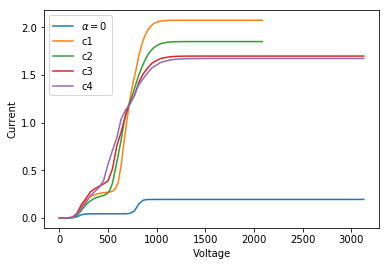

In [95]:
plt.plot(v0, c0, label=r'$\alpha=0$')

plt.plot(v1, c1, label=r'c1')
plt.plot(v2, c2, label=r'c2')
plt.plot(v3, c3, label=r'c3')
plt.plot(v4, c4, label=r'c4')
#plt.plot(v5, c5, label=r'c5')
"""
plt.plot(v4, c4, label=r'$\alpha=50, \Gamma=25$')
plt.plot(v5, c5, label=r'$\alpha=50, \omega_0=100$')"""
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.legend()
plt.show()

- Broadening $\Gamma$ seems to have no effect on current output which is strange.


In [ ]:
reload(fl)
reload(RC)
def current_vs_phonon_coupling(eps1, eps2, T_ph=77., Gamma=30., w0=70., U=0., N=10,
                               gamma_L=1., T_L=77., mu_L=1000., width_L=1000., pos_L=1000.,
                               gamma_R=1., T_R=77., mu_R=0., width_R=1000., pos_R=1000.,
                               height_L=1., height_R=1.):
    ti = time.time()
    eps = abs(eps2-eps1)
    alpha_prop = np. linspace(0, 1., 50)
    print "RC would need {} states to fill electronic gap.".format(eps/w0)
    currents_nonadd = []
    #timelist = np.linspace(0, 3/Gamma_EM, 360)
    H = build_H(eps1, eps2, U)
    d_RC = tensor(d1+d2, qeye(N))
    E_RC = tensor(n, qeye(N))
    
    #timelist = np.linspace(0, 3/Gamma_EM, 360)

    for i, alphap in enumerate(alpha_prop):
        alpha_ph = alphap*eps/pi
        
        L_RC, H_RC, A_EM, A_nrwa, Z, _, _, _, = RC_function_UD(H, n, d1+d2, T_ph, Gamma, w0, alpha_ph, 
                                                             N, silent=True)
        L_Lfull, L_Rfull = L_R_lead_dissipators(H_RC, d_RC, T_L=T_L, mu_L=mu_L,
                         width_L=width_L, pos_L=pos_L, height_L=height_L, T_R=T_R,
                         mu_R=mu_R, width_R=width_R, pos_R=pos_R, height_R=height_R)
        #currents_add.append(current_from_L(H_RC, L_RC+L_Ladd+L_Radd, L_Radd, E_RC))
        currents_nonadd.append(current_from_L(H_RC, L_RC+L_Lfull+L_Rfull, L_Rfull, E_RC))
        if (i%10)==0:
            print 100*(float(i)/len(alpha_prop)), "% complete"
    print "Took {} seconds.".format(time.time()-ti)
    return alpha_prop,  currents_nonadd

N = 10
a_prop1,  pc1 = current_vs_phonon_coupling(1000., 200., T_ph=77., Gamma=30., w0=50.,
                                           N=10, T_L=77., T_R=77., mu_R=0., mu_L=1000.)
a_prop2, pc2 = current_vs_phonon_coupling(1000., 200., T_ph=77., Gamma=30., w0=70.,
                                           N=10, T_L=77., T_R=77., mu_R=0., mu_L=1000.)
a_prop2, pc3 = current_vs_phonon_coupling(1000., 200., T_ph=77., Gamma=100., w0=70.,
                                           N=10, T_L=77., T_R=77., mu_R=0., mu_L=1000.)

RC would need 16.0 states to fill electronic gap.
0.0 % complete
20.0 % complete
40.0 % complete
60.0 % complete
80.0 % complete


In [78]:
(0.695*77)/1000.

0.05351499999999999

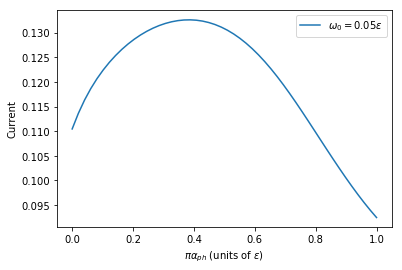

In [101]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(a_prop1, pc1, label=r'$\omega_0=0.05\epsilon$', color=colors[0])
"""plt.plot(a_prop1, c1a, color=colors[0], ls='dashed')
plt.plot(a_prop2, c2na, label=r'$\omega_0=0.1\epsilon$', color=colors[1])
plt.plot(a_prop2, c2na, label=r'$\omega_0=0.1\epsilon, \mu_L=1.5\epsilon$ ', color=colors[2])
plt.plot(a_prop2, c2a, color=colors[1], ls='dashed')"""
plt.legend()
plt.xlabel(r"$\pi\alpha_{ph}$ (units of $\epsilon$)")
plt.ylabel("Current")

From the above analysis, we can see:
- "subband" behaviour is not seen, i.e. when the voltage gap includes more vibration levels, this does not lead to enhanced transport. I would have thought it is a combination of the electron-phonon coupling $\sigma_z$ not causing transitions and the weak-coupling approximation in the leads.
- Higher phonon coupling leads to a decrease in current, presumably due to the population relaxing down the some higher lying vibronic state rather than the electronic ground so less energy is available to be extracted?
- Additive lead coupling sees no phonon-coupling dependence on current.
- Lower frequency modes lead to slightly lower currents - either a convergence problem or something to do with the way energy is distributed (lower) when you have more states to occupy.

## Photocurrent

RC would need 20.0 states to fill electronic gap.
0.0 % complete
33.3333333333 % complete
66.6666666667 % complete
Took 0.414345026016 seconds.
RC would need 20.0 states to fill electronic gap.
0.0 % complete
33.3333333333 % complete
66.6666666667 % complete
Took 0.395993947983 seconds.
RC would need 20.0 states to fill electronic gap.
0.0 % complete
33.3333333333 % complete
66.6666666667 % complete
Took 0.693045139313 seconds.
RC would need 20.0 states to fill electronic gap.
0.0 % complete
33.3333333333 % complete
66.6666666667 % complete
Took 0.307703018188 seconds.
RC would need 20.0 states to fill electronic gap.
0.0 % complete
33.3333333333 % complete
66.6666666667 % complete
Took 0.306739091873 seconds.


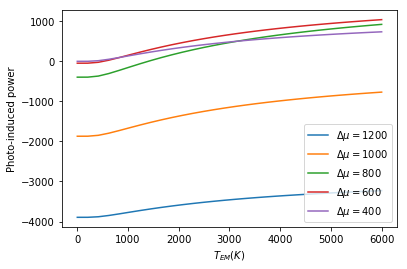

In [58]:
def photopower_vs_T_EM(eps, Gamma_EM=1.,
                       Gamma_L=1., T_L=77., mu_L=100.,  width_L=1000., pos_L=1000.,
                       Gamma_R=1., T_R=77., mu_R=900., width_R=1000., pos_R=1000.):
    ti = time.time()
    T_EM_list = np. linspace(0, 6000., 30)
    print "RC would need {} states to fill electronic gap.".format(eps/w0)
    currents = []
    L_RC, H_RC, A_EM, A_nrwa, Z, _, _, _, = RC_function_UD(H, n, d1+d2, T_ph, Gamma, w0, alpha_ph, 
                                                             N, silent=True)
    #timelist = np.linspace(0, 3/Gamma_EM, 360)
    for i, T_EM in enumerate(T_EM_list):
        L_EM = L_non_rwa(H_vib, A, w_0, alpha, T_EM, J, principal=False, silent=False)
        #L_EM = EM.L_EM_lindblad(eps, d, Gamma_EM, T_EM, J_EM, silent=True)
        L_L = additive_lead_dissipator(eps, d, T_L, mu_L, Gamma_L)
        L_R = additive_lead_dissipator(eps, d, T_R, mu_R, Gamma_R)
        currents.append(current_from_L(H, L_EM+L_L+L_R, L_R, E))
        if (i%10)==0:
            print 100*(float(i)/len(T_EM_list)), "% complete"
    print "Took {} seconds.".format(time.time()-ti)
    return T_EM_list, (mu_R-mu_L)*np.array(currents)

T = 77.
g_ = 1.
T1, P1 = photopower_vs_T_EM(eps, T_L=T, T_R=T,
                         mu_L=-100., mu_R=1100., Gamma_EM=3.*g_, Gamma_L=g_)
T2, P2 = photopower_vs_T_EM(eps, T_L=T, T_R=T,
                         mu_L=0., mu_R=1000., Gamma_EM=3.*g_, Gamma_L=g_)
T3, P3 = photopower_vs_T_EM(eps, T_L=T, T_R=T,
                         mu_L=100., mu_R=900., Gamma_EM=3.*g_, Gamma_L=g_)
T4, P4 = photopower_vs_T_EM(eps, T_L=T, T_R=T,
                         mu_L=200., mu_R=800., Gamma_EM=3.*g_, Gamma_L=g_)
T5, P5 = photopower_vs_T_EM(eps, T_L=T, T_R=T,
                         mu_L=300., mu_R=700., Gamma_EM=3.*g_, Gamma_L=g_)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(T1, P1, label=r'$\Delta\mu=1200$', color=colors[0])
plt.plot(T1, P2, label=r'$\Delta\mu=1000$', color=colors[1])
plt.plot(T1, P3, label=r'$\Delta\mu=800$', color=colors[2])
plt.plot(T1, P4, label=r'$\Delta\mu=600$', color=colors[3])
plt.plot(T1, P5, label=r'$\Delta\mu=400$', color=colors[4])
plt.legend()
plt.xlabel(r"$T_{EM} (K)$")
plt.ylabel("Photo-induced power")

In [59]:
from numpy import sqrt
from fermionic_leads import rate_up, rate_down
import utils as ut

def hopping_model(llplus_gap, lzero_gap, Gamma_EM=5., T_EM=6000.,
                  Gamma_L=1., T_L=77., mu_L=100., 
                  Gamma_R=1., T_R=77., mu_R=900.):
    lumoplus = basis(3, 2)
    lumo = basis(3, 1)
    zero = basis(3, 0)
    H = llplus_gap*lumoplus*lumoplus.dag() + 0*lumo*lumo.dag() + -lzero_gap*zero*zero.dag()
    col_L = lumo*zero.dag()
    col_R = lumoplus*zero.dag()
    col_EM = lumoplus*lumo.dag()
    # Check 
    L_L = rate_down(lzero_gap, T_L, mu_L, Gamma_L)*qt.lindblad_dissipator(col_EM)
    L_L += rate_up(lzero_gap, T_L, mu_L, Gamma_L)*qt.lindblad_dissipator(col_EM.dag())
    L_R = rate_down(llplus_gap+lzero_gap, T_R, mu_R, Gamma_R)*qt.lindblad_dissipator(col_EM)
    L_R += rate_up(llplus_gap+lzero_gap, T_R, mu_R, Gamma_R)*qt.lindblad_dissipator(col_EM.dag())
    
    n_EM = ut.Occupation(llplus_gap, T_EM)
    L_EM = pi*Gamma_EM*((1+n_EM)*qt.lindblad_dissipator(col_EM)+n_EM*qt.lindblad_dissipator(col_EM.dag()))
    return H, L_L, L_R, L_EM


def current_from_L(H, L_full, L_track, n):
    rho_ss = qt.steadystate(H, [L_full])
    time_dependence = (qt.vector_to_operator(L_track*qt.operator_to_vector(rho_ss))*n).tr()
    return -time_dependence


H, L_L, L_R, L_EM = hopping_model(1000., 100., Gamma_EM=1., T_EM=6000.,
                                    Gamma_L=1., T_L=77., mu_L=3000., 
                                    Gamma_R=1., T_R=77., mu_R=0.)
rho_ss = qt.steadystate(H, [L_L+L_R+L_EM])
lumoplus = basis(3, 2)
print current_from_L(H, L_L+L_R+L_EM, L_R, lumoplus*lumoplus.dag())
print rho_ss

TypeError: rate_down() takes exactly 7 arguments (4 given)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.        ]
 [ 0.          0.43349726  0.        ]
 [ 0.          0.          0.56650274]] Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.]
 [ 0.]
 [ 1.]]


In [46]:
def photocurrent_vs_phonon_coupling(eps, T_ph, Gamma, w0, T_EM=5800., N=10, 
                                    T_L=77., T_R=77., mu_L=100., mu_R=900.,
                                    Gamma_EM=1.):
    ti = time.time()
    alpha_prop = np. linspace(0, 1., 50)
    print "RC would need {} states to fill electronic gap.".format(eps/w0)
    currents_add = []
    currents_nonadd = []
    d_RC = tensor(d, qeye(N))
    E_RC = tensor(E, qeye(N))
    
    #timelist = np.linspace(0, 3/Gamma_EM, 360)
    for i, alphap in enumerate(alpha_prop):
        alpha_ph = alphap*eps/pi
        L_RC, H_RC, A_EM, A_nrwa, Z, _, _, _, = RC.RC_function_UD(d, eps, T_ph, Gamma, w0, alpha_ph, 
                                                         N, silent=True)
        L_EM_add = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J_EM, silent=True)
        L_EM_full = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True)
        L_L_add = additive_lead_dissipator(eps, d_RC, T_L, mu_L, Gamma_l)
        L_R_add = additive_lead_dissipator(eps, d_RC, T_R, mu_R, Gamma_l)
        L_L_full, L_R_full = fl.L_R_lead_dissipators(H_RC, d_RC, eps, T_L, mu_L, Gamma_l, T_R, mu_R, Gamma_l)
        currents_add.append(current_from_L(H_RC, L_RC+L_EM_add+L_L_add+L_R_add, L_R_add, E_RC))
        currents_nonadd.append(current_from_L(H_RC, L_RC+L_EM_full+L_L_full+L_R_full, L_R_full, E_RC))
        if (i%10)==0:
            print 100*(float(i)/len(alpha_prop)), "% complete"
    print "Took {} seconds.".format(time.time()-ti)
    return alpha_prop, currents_add, currents_nonadd

# assume that the molecule and the leads are in thermal equilibrium
T = 77.
ap, pca1, pcna1 = photocurrent_vs_phonon_coupling(1000., T, 10., 100., T_EM=5800., N=10, 
                                    T_L=T, T_R=T, mu_R=900., mu_L=100.,
                                    Gamma_EM=1.)
T = 100.
ap, pca2, pcna2 = photocurrent_vs_phonon_coupling(1000., T, 10., 100., T_EM=5800., N=10, 
                                    T_L=T, T_R=T, mu_R=900., mu_L=100.,
                                    Gamma_EM=1.)
T = 150.
ap, pca3, pcna3 = photocurrent_vs_phonon_coupling(1000., 150., 10., 100., T_EM=5800., N=10, 
                                    T_L=T, T_R=T, mu_R=900., mu_L=100.,
                                    Gamma_EM=1.)

RC would need 10.0 states to fill electronic gap.
0.0 % complete
20.0 % complete
40.0 % complete
60.0 % complete
80.0 % complete
Took 81.8650860786 seconds.
RC would need 10.0 states to fill electronic gap.
0.0 % complete
20.0 % complete
40.0 % complete
60.0 % complete
80.0 % complete
Took 78.517111063 seconds.
RC would need 10.0 states to fill electronic gap.
0.0 % complete
20.0 % complete
40.0 % complete
60.0 % complete
80.0 % complete
Took 78.7262010574 seconds.


In [41]:
0.695*150./1000, 0.695*77/1000.

(0.10424999999999998, 0.05351499999999999)

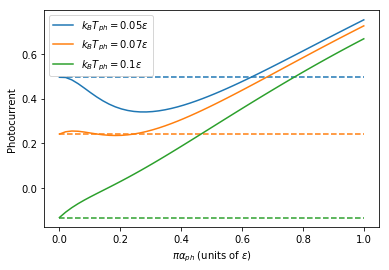

In [49]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(ap, pcna1, label=r'$k_B T_{ph}=0.05\epsilon$', color=colors[0])
plt.plot(ap, pca1, color=colors[0], ls='dashed')
plt.plot(ap, pcna2, label=r'$k_B T_{ph}=0.07\epsilon$', color=colors[1])
plt.plot(ap, pca2, color=colors[1], ls='dashed')
plt.plot(ap, pcna3, label=r'$k_B T_{ph}=0.1\epsilon$', color=colors[2])
plt.plot(ap, pca3, color=colors[2], ls='dashed')
plt.legend()
plt.xlabel(r"$\pi\alpha_{ph}$ (units of $\epsilon$)")
plt.ylabel("Photocurrent")